In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

In [42]:
#import packages
#feel free to import more if you need

#evaluate the benign accuracy of a model
def test(model, x,y,batch_size):
    model.eval()
    total=x.shape[0]
    batches=np.ceil(total/batch_size).astype(int)
    success=0
    loss=0
    for i in range(batches):
        start_index=i*batch_size
        end_index=np.minimum((i+1)*batch_size,total)
        x_batch=torch.tensor(x[start_index:end_index]).float()
        y_batch=torch.tensor(y[start_index:end_index]).long()
        output=model(x_batch)
        pred=torch.argmax(output,dim=1)
        loss+=F.cross_entropy(output,y_batch).item()
        success+=(pred==y_batch).sum().item()
    print ("accuracy: "+str(success/total))


#define model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

#load MNIST
dataset_train = datasets.MNIST('../data', train=True, download=True)
dataset_test = datasets.MNIST('../data', train=False, download=True)

# reshape MNIST
x_train=dataset_train.data.numpy()
y_train=dataset_train.targets.numpy()
x_test=dataset_test.data.numpy()
y_test=dataset_test.targets.numpy()
x_train=np.reshape(x_train,(60000,28,28,1))
x_test=np.reshape(x_test,(10000,28,28,1))
x_train=np.swapaxes(x_train, 1, 3)
x_test=np.swapaxes(x_test, 1, 3)


#REMINDER: the range of inputs is different from what we used in the recitation
print (x_test.min(),x_test.max())


modelA=Net()
modelA.load_state_dict(torch.load("modelA.zip"))
test(modelA,x_test,y_test,512)
modelB=Net()
modelB.load_state_dict(torch.load("modelB.zip"))
test(modelB,x_test,y_test,512)


#untargeted attack
#you may add parameters as you wish
def untargeted_attack(model, x,y,epsilon, iterations):
    x = x / 255.0

    # x is inout inage
    # y is true labeks
    # use fast gradient sign method
    model.eval()
    x = torch.tensor(x).clone().detach().float().requires_grad_(True)
    y = torch.tensor(y).clone().detach().long()
    for _ in range(iterations):
        out = model(x) # do a forward pass
        loss = F.cross_entropy(out, y)
        model.zero_grad()
        loss.backward()
        grad_info = x.grad.data
        sign_grad =grad_info.sign()
        adversarial = x + epsilon * sign_grad # maximize loss
        adversarial = torch.clamp(adversarial, 0, 1)  # Keep adversarial images within [0, 1]
        adversarial = adversarial.requires_grad_(True)

    adversarial *=255.0
    
    return adversarial

#targeted attack
def targeted_attack(model, x, epsilon, iterations):
    x = x / 255.0
    target_class = 8  
    x = torch.tensor(x).clone().detach().float().requires_grad_(True)
    y = torch.full((x.shape[0],), target_class, dtype=torch.long)
    
    for _ in range(iterations):
        out = model(x)
        loss = F.cross_entropy(out, y)
        model.zero_grad()
        loss.backward()
        grad_sign = x.grad.data.sign()
        adversarial = x - epsilon * grad_sign  
        adversarial = torch.clamp(adversarial, 0, 1).requires_grad_(True)

    adversarial *= 255.0
    return adversarial

#improved targeted attack 
# do pgd that camps perturbation, 
def targeted_attack_improved(model, x, y, epsilon, iterations):
    model.eval()
    x = x / 255.0
    original_x = x.clone().detach()
    adversarial = x.clone().detach().requires_grad_(True)
    for _ in range(iterations):
        output = model(adversarial)
        loss = F.cross_entropy(output, y)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            adversarial = adversarial + epsilon * adversarial.grad.sign()
            perturbation = torch.clamp(adversarial - original_x, min=-epsilon, max=epsilon)
            adversarial = torch.clamp(original_x + perturbation, min=0, max=1).detach_().requires_grad_(True)
    adversarial =adversarial *  255.0

    return adversarial
#evaluate performance of attacks
	#TODO
def test_attack(model, attack_type, images, labels, epsilon, num_iter, model_Name):
    model.eval()
    normal_pred_lst= []
    adversarial_pred_lst = []
    adv_img_lst = []

    for i in range(images.size(0)):
        img_i = images[i].unsqueeze(0)
        label_i = labels[i].unsqueeze(0)
        normal_pred = model(img_i) # torch.Size([1, 10])
        _, idx_max_norm = torch.max(normal_pred,1)
        if attack_type.__name__ == "untargeted_attack":
            adver_img = attack_type(model,img_i,label_i, epsilon, num_iter)

            
        elif attack_type.__name__ == "targeted_attack":
            adver_img = attack_type(model,img_i, epsilon, num_iter)



        else: # pgd
            # (model, x, y, epsilon, alpha, iterations):
            adver_img = attack_type(model,img_i,label_i, epsilon, num_iter)

        # print(f'num of iterations: {iterations}')

        adversarial_pred = model(adver_img)
        _, idx_max_adv= torch.max(adversarial_pred,1)
        
        normal_pred_lst.append(idx_max_norm.item())
        adversarial_pred_lst.append(idx_max_adv.item())
        adv_img_lst.append(adver_img)


        
    if attack_type.__name__ == "untargeted_attack":
        misclassif_rate =np.sum(np.array(normal_pred_lst) != np.array(adversarial_pred_lst))/len(adversarial_pred_lst)
        print(f'Prediction Rate (when adversarial image is not predicted as original) for {attack_type.__name__}, {model_Name} for epsilon: {epsilon}: {misclassif_rate}')
        return np.array(normal_pred_lst),np.array(adversarial_pred_lst), misclassif_rate, adv_img_lst
    elif attack_type.__name__ == "targeted_attack":
        misclassif_rate =np.sum(np.array(adversarial_pred_lst) == 8)/len(adversarial_pred_lst)
        print(f'Prediction rate (when adversarial image is predicted as 8) for {attack_type.__name__}, {model_Name} for epsilon: {epsilon}: {misclassif_rate}')
        return np.array(normal_pred_lst),np.array(adversarial_pred_lst), misclassif_rate, adv_img_lst
    elif attack_type.__name__ == "targeted_attack_improved":
        misclassif_rate =np.sum(np.array(normal_pred_lst) != np.array(adversarial_pred_lst))/len(adversarial_pred_lst)
        print(f'Prediction Rate (when adversarial image is not predicted as original) for {attack_type.__name__}, {model_Name} for epsilon: {epsilon}: {misclassif_rate}')
        return np.array(normal_pred_lst),np.array(adversarial_pred_lst), misclassif_rate, adv_img_lst
    else:
        return("Error")
def plot_imgs(idx, adv,predict,adv_predict, funct_name,epsilon, model_name):
    original =x_test[idx].squeeze(0)
    print("a problem")
    print(len(adv))
    adversarial = adv[idx].squeeze(0,1).detach().numpy()
    # Plot the image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.colorbar() 
    plt.title(f'Original Image is classifed as {predict[idx]}')

    plt.subplot(1, 2, 2)
    plt.imshow(adversarial, cmap='gray')
    plt.colorbar() 
    plt.title(f'Adversarial Image is classifed as {adv_predict[idx]}')

    plt.suptitle(f'{funct_name} Attack with Epsilon = {epsilon} for {model_name}')

    filename = f"{funct_name}_epsilon_{epsilon}.png"
    plt.savefig(f"{filename}")


imgs, labels = x_test, y_test  # Example: selecting the first 10 test images
imgs = torch.tensor(imgs).float()  # Convert images to float tensors
labels = torch.tensor(labels)
idx = 3 # index of image for plotting




# pred, adv_pred, misclass_rate, adversarial_images = test_attack(modelA, targeted_attack, imgs,labels,  epsilon, num_iter)
# plot_imgs(0,adversarial_images)


0 255
accuracy: 0.9856
accuracy: 0.9839


/var/folders/2r/7py1k97d4t7g75mlb4ct7n4r0000gn/T/ipykernel_74382/3889826670.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).clone().detach().float().requires_grad_(True)


Prediction rate (when adversarial image is predicted as 8) for targeted_attack, modelA for epsilon: 0.5: 0.7154
a problem
10000


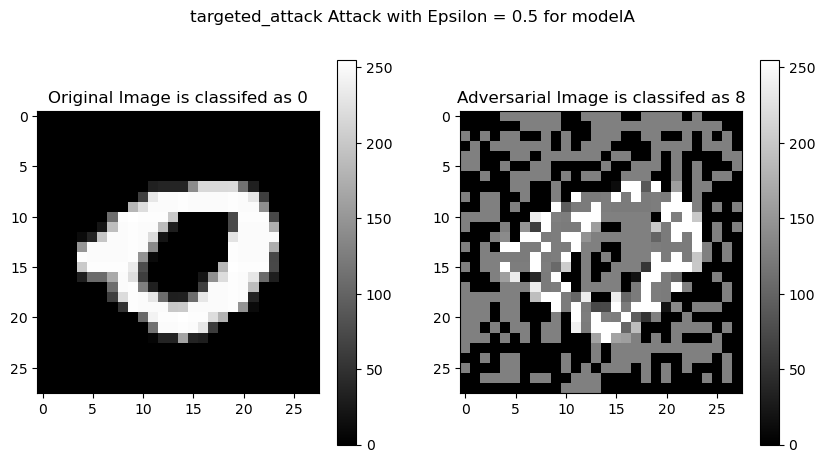

In [46]:
num_iter = 5
epsilon_lst = [0.5]
success_A_targeted_improved_ = []

for epsilon in epsilon_lst:
    pred, adv_pred, misclass_rate, adversarial_images = test_attack(modelA, targeted_attack, imgs,labels,  epsilon, num_iter,"modelA")
    plot_imgs(idx,adversarial_images,pred,adv_pred, targeted_attack.__name__,epsilon,"modelA")
    success_A_targeted_improved_.append(misclass_rate)

In [44]:
num_iter = 50
epsilon_lst = [0.01, 0.05, 0.1, 0.15,0.2,0.25, 0.3,0.4,0.5 ]
success_A_targeted_improved = []

for epsilon in epsilon_lst:
    pred, adv_pred, misclass_rate, adversarial_images = test_attack(modelA, targeted_attack_improved, imgs,labels,  epsilon, num_iter,"modelA")
    plot_imgs(idx,adversarial_images,pred,adv_pred, targeted_attack_improved.__name__,epsilon,"modelA")
    success_A_targeted_improved.append(misclass_rate)

KeyboardInterrupt: 

In [ ]:
num_iter = 50
epsilon_lst = [0.01, 0.05, 0.1, 0.15,0.2,0.25, 0.3,0.4,0.5 ]
success_B_targeted_improved = []

for epsilon in epsilon_lst:
    pred, adv_pred, misclass_rate, adversarial_images = test_attack(modelB, targeted_attack_improved, imgs,labels,  epsilon, num_iter,"modelB")
    plot_imgs(idx,adversarial_images,pred,adv_pred, targeted_attack_improved.__name__,epsilon,"modelB")
    success_B_targeted_improved.append(misclass_rate)

NameError: name 'test_attack' is not defined

In [6]:
success_rates = [
    success_A_untargeted_attack,
    success_B_untargeted_attack,
    success_A_targeted,
    success_B_targeted,
    success_A_targeted_improved,
    success_B_targeted_improved
]

titles = [
    "Success Rate of A with Untargeted Attack",
    "Success Rate of B with Untargeted Attack",
    "Success Rate of A with Targeted Attack",
    "Success Rate of B with Targeted Attack",
    "Success Rate of A with Targeted Improved Attack",
    "Success Rate of B with Targeted Improved Attack"
]

for i, success_rate in enumerate(success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_lst, success_rate, marker='o')
    plt.title(titles[i])
    plt.xlabel("Epsilon")
    plt.ylabel("Success Rate")
    plt.grid(True)
    plt.show()

NameError: name 'success_A_untargeted_attack' is not defined